In [35]:
import datetime
import time
import unittest
import pandas as pd
import pytz
import matplotlib.pyplot as plt

In [36]:
from tigeropen.common.consts import BarPeriod
from tigeropen.quote.quote_client import QuoteClient
from tigeropen.tiger_open_config import TigerOpenClientConfig

In [37]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [38]:
def get_client_config():
    """
    https://quant.itigerup.com/#developer 开发者信息获取
    """
    # 港股牌照需用 props_path 参数指定token路径，如 '/Users/xxx/xxx/', 如不指定则取当前路径
    client_config = TigerOpenClientConfig(props_path='tiger_openapi_config.properties')
    return client_config

In [39]:
# 调用上方定义的函数生成用户配置ClientConfig对象
client_config = get_client_config()

# 随后传入配置参数对象来初始化QuoteClient
quote_client = QuoteClient(client_config)

SYMBOL = "symbol"
TIME = "time"
CLOSE = "close"
DATE = "date"

# 需要请求的k线bar的总个数.  total number of requested bars.
BARS_TOTAL_NUMBER = 2000

# 每次请求bar的个数，系统限制每个symbol每次最多请求1200个bar.
# number of bars per request, the system limits each symbol to a maximum of 1200 bars per request.
BARS_BATCH_SIZE = 300

# 每次请求symbol的个数，系统限制每次最多请求50个symbol
# number of symbols per request, the system limits each request to a maximum of 50 symbols.
SYMBOLS_BATCH_SIZE = 50

# 每次请求的间隔时间，防止过快的请求频率触发系统限流. 单位：秒
# The interval between each request, to prevent requests too fast to trigger the system rate limit. Time unit: second
REQUEST_INTERVAL = 0.5

In [40]:
def request_bars(symbols, period, end_time, bars_batch_size):
        """
        请求k线. Request history bars.
        :param symbols: like ['AAPL', 'TSLA']
        :param period: k线周期. tigeropen.common.consts.BarPeriod. like BarPeriod.DAY
        :param end_time: end time in timestamp format. like 1645499400000
        :param bars_batch_size: 每个symbol限制请求的bar数量. bars limit size of each symbol
        :return:
        """
        symbols = list(symbols)
        result = pd.DataFrame()
        for i in range(0, len(symbols), SYMBOLS_BATCH_SIZE):
            part = symbols[i:i + SYMBOLS_BATCH_SIZE]
            quote = quote_client.get_bars(part, period=period, end_time=end_time, limit=bars_batch_size)
            #result = result.append(quote)
            result = pd.concat([result, quote])
            # to avoid rate limit
            time.sleep(REQUEST_INTERVAL)
        return result

In [41]:
# US market
symbols = ['BABA', 'PDD', 'JD', 'NTES', 'NIO', 'XPEV', 'LI']
timezone = 'US/Eastern'

end = int(datetime.datetime.today().timestamp() * 1000)
history = pd.DataFrame()
for i in range(0, BARS_TOTAL_NUMBER, BARS_BATCH_SIZE):
    if i + BARS_BATCH_SIZE <= BARS_TOTAL_NUMBER:
        limit = BARS_BATCH_SIZE
    else:
        limit = i + BARS_BATCH_SIZE - BARS_TOTAL_NUMBER
    end_time = datetime.datetime.fromtimestamp(end/1000, pytz.timezone(timezone))
    print(f'query {len(symbols)} symobls history, end_time:{end} -- {end_time}, limit:{limit}')
    # 其他周期可修改period参数. 
    part = request_bars(symbols=symbols, period=BarPeriod.MONTH, end_time=end, bars_batch_size=BARS_BATCH_SIZE)
    part[DATE] = pd.to_datetime(part[TIME], unit='ms').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if (len(part[TIME]) == 0): 
        break
    end = min(part[TIME])
    history = pd.concat([history, part])
history.set_index([DATE], inplace=True)
history.sort_index(inplace=True)

# 2014年9月1日
history.drop(history[history[TIME] < 1409500800000].index, inplace=True)

history.drop('time', axis=1, inplace=True)
history.drop('amount', axis=1, inplace=True)
history.drop('next_page_token', axis=1, inplace=True)

print(history)

query 7 symobls history, end_time:1707014407126 -- 2024-02-03 21:40:07.126000-05:00, limit:300
query 7 symobls history, end_time:959832000000 -- 2000-06-01 00:00:00-04:00, limit:300
                          symbol     open     high      low    close     volume
date                                                                           
2014-09-01 00:00:00-04:00   NTES   17.544   18.140   16.774   17.132   24260500
2014-09-01 00:00:00-04:00     JD   32.000   32.350   25.300   25.820  108197700
2014-09-01 00:00:00-04:00   BABA   92.700   99.700   86.620   88.850  454681100
2014-10-01 00:00:00-04:00   NTES   17.212   19.158   16.284   18.944   51385500
2014-10-01 00:00:00-04:00   BABA   88.700  100.670   82.810   98.600  399677000
...                          ...      ...      ...      ...      ...        ...
2024-02-01 00:00:00-05:00    NIO    5.730    5.915    5.430    5.540  108346952
2024-02-01 00:00:00-05:00   NTES  100.290  101.760   98.185   98.830    2459591
2024-02-01 00:00:0

In [42]:
ind = history.groupby('date').agg({'open':'sum', 'high':'sum', 'low':'sum', 'close':'sum', 'volume':'sum'}).reset_index()
indexation = pd.DataFrame(ind)
indexation.set_index([DATE], inplace=True)
indexation.sort_index(inplace=True)

print(indexation)

                              open      high      low    close      volume
date                                                                      
2014-09-01 00:00:00-04:00  142.244  150.1900  128.694  131.802   587139300
2014-10-01 00:00:00-04:00  131.432  146.6180  121.694  141.434   546810500
2014-11-01 00:00:00-04:00  142.368  169.8940  140.676  156.294   803599100
2014-12-01 00:00:00-05:00  154.490  158.8200  142.026  146.908   512507200
2015-01-01 00:00:00-05:00  147.574  154.5880  129.690  135.770   502175600
...                            ...       ...      ...      ...         ...
2023-10-01 00:00:00-04:00  377.268  406.2363  348.760  371.890  1784067732
2023-11-01 00:00:00-04:00  372.155  453.2400  359.580  424.060  2078303678
2023-12-01 00:00:00-05:00  416.430  435.3050  365.560  406.960  2835371119
2024-01-01 00:00:00-05:00  398.980  420.9700  336.870  360.860  2890076288
2024-02-01 00:00:00-05:00  365.955  371.3373  354.725  359.120   231815612

[114 rows x 5 columns]


In [43]:
import cufflinks as cf

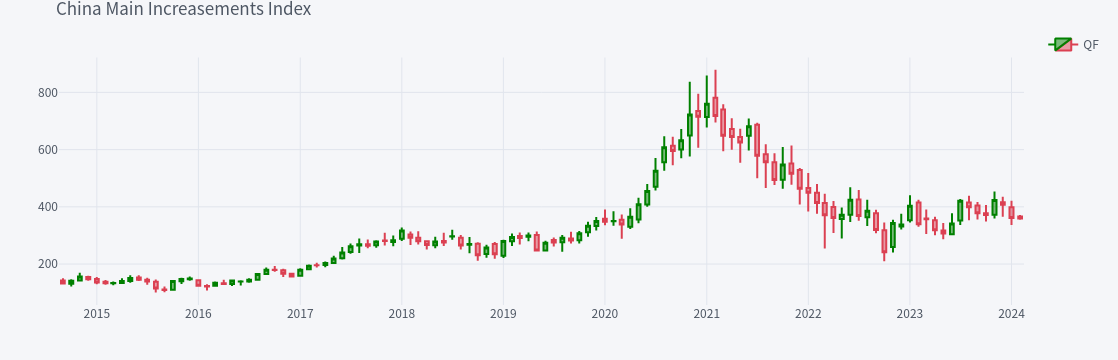

In [44]:
cf.set_config_file(offline=True, world_readable=True)
qf = cf.QuantFig(indexation, title="China Main Increasements Index", legend="right", name="QF")
#qf.add_volume()
# qf.add_trendline('2014-09-01','2024-01-01',on='close',textangle=0)
qf.iplot(up_color='green',down_color='red')

In [45]:
close = indexation[CLOSE]
# 计算月收益率
returns = close.pct_change().dropna()
# 计算滚动的12月历史波动性（标准差）
volatility = returns.rolling(window=12).std()
# 查看有效月份的年化波动性
volatility.dropna(inplace=True)
print(volatility)

date
2015-09-01 00:00:00-04:00    0.079903
2015-10-01 00:00:00-04:00    0.116332
2015-11-01 00:00:00-04:00    0.113288
2015-12-01 00:00:00-05:00    0.111651
2016-01-01 00:00:00-05:00    0.120954
                               ...   
2023-10-01 00:00:00-04:00    0.166107
2023-11-01 00:00:00-04:00    0.122088
2023-12-01 00:00:00-05:00    0.123056
2024-01-01 00:00:00-05:00    0.115901
2024-02-01 00:00:00-05:00    0.105065
Name: close, Length: 102, dtype: float64


In [46]:
# 计算每月的绝对价格变动
absolute_price_change = close.diff()
absolute_price_change.dropna(inplace=True)
print(absolute_price_change)

date
2014-10-01 00:00:00-04:00     9.632
2014-11-01 00:00:00-04:00    14.860
2014-12-01 00:00:00-05:00    -9.386
2015-01-01 00:00:00-05:00   -11.138
2015-02-01 00:00:00-05:00    -2.972
                              ...  
2023-10-01 00:00:00-04:00    -5.260
2023-11-01 00:00:00-04:00    52.170
2023-12-01 00:00:00-05:00   -17.100
2024-01-01 00:00:00-05:00   -46.100
2024-02-01 00:00:00-05:00    -1.740
Name: close, Length: 113, dtype: float64


In [47]:
volume = indexation['volume']
# 市场数据组合
market_data = pd.concat([volume, volatility, absolute_price_change], axis = 1, ignore_index=False)
market_data.columns = ['market_volume', 'volatility', 'price_change']
market_data.dropna(how='any', inplace=True)
print(market_data)

                           market_volume  volatility  price_change
date                                                              
2015-09-01 00:00:00-04:00      792055437    0.079903        -5.182
2015-10-01 00:00:00-04:00      744189221    0.116332        31.302
2015-11-01 00:00:00-04:00      886489387    0.113288         7.736
2015-12-01 00:00:00-05:00      589575942    0.111651         1.691
2016-01-01 00:00:00-05:00      712294371    0.120954       -25.495
...                                  ...         ...           ...
2023-10-01 00:00:00-04:00     1784067732    0.166107        -5.260
2023-11-01 00:00:00-04:00     2078303678    0.122088        52.170
2023-12-01 00:00:00-05:00     2835371119    0.123056       -17.100
2024-01-01 00:00:00-05:00     2890076288    0.115901       -46.100
2024-02-01 00:00:00-05:00      231815612    0.105065        -1.740

[102 rows x 3 columns]


In [48]:
def calculate_fear_greed_index(data):
    # 标准化数据
    normalized_volatility = (data['volatility'] - data['volatility'].min()) / (data['volatility'].max() - data['volatility'].min())
    normalized_volume = (data['market_volume'] - data['market_volume'].min()) / (data['market_volume'].max() - data['market_volume'].min())
    normalized_price_change = (data['price_change'] - data['price_change'].min()) / (data['price_change'].max() - data['price_change'].min())
    # 定义恐慌和贪婪的权重
    volatility_weight = 0.4
    volume_weight = 0.3
    price_change_weight = 0.3
    # 计算指数
    data['fear_greed_index'] = (normalized_volatility * volatility_weight + 
                                 normalized_volume * volume_weight + 
                                 normalized_price_change * price_change_weight) * 100
    return data

In [49]:
# 计算恐慌贪婪指数
fear_greed_index_data = calculate_fear_greed_index(market_data)
print(fear_greed_index_data['fear_greed_index'])

date
2015-09-01 00:00:00-04:00    25.796836
2015-10-01 00:00:00-04:00    40.709855
2015-11-01 00:00:00-04:00    36.958748
2015-12-01 00:00:00-05:00    34.574403
2016-01-01 00:00:00-05:00    33.528578
                               ...    
2023-10-01 00:00:00-04:00    52.407099
2023-11-01 00:00:00-04:00    50.075208
2023-12-01 00:00:00-05:00    42.915539
2024-01-01 00:00:00-05:00    36.956327
2024-02-01 00:00:00-05:00    31.029897
Freq: MS, Name: fear_greed_index, Length: 102, dtype: float64


/home/zhangruian/.local/lib/python3.11/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



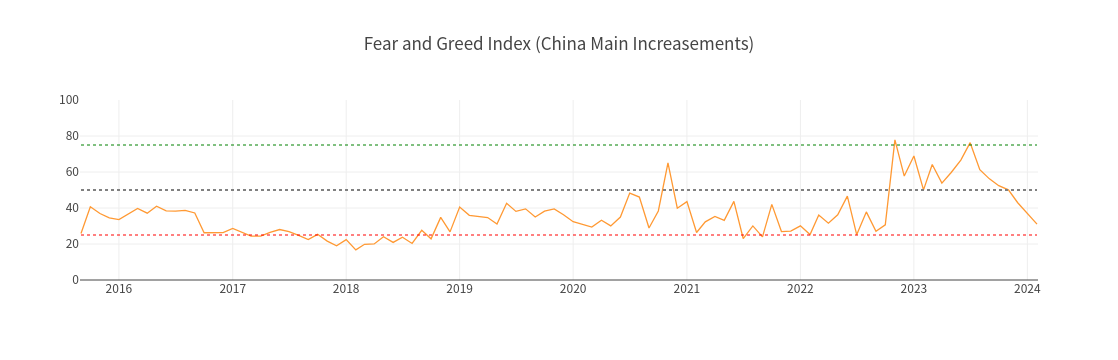

In [50]:
layout = {
    'shapes': [
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 75,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 75,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'green',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 50,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 50,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'gray',
                'width': 2,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 25,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 25,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'red',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        }
    ],
    'yaxis': {
        'range': [0, 100]  # 设置y轴的最小值和最大值
    },
    'y0': 50,  # 指定线的y值
    'title': 'Fear and Greed Index (China Main Increasements)'
}

fear_greed_index_data['fear_greed_index'].iplot(kind='line', layout=layout)